In [1]:
import torch
from torch import nn, optim
import numpy as np
# Set the random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

In [2]:
class SurrogateNN(nn.Module):
    def __init__(self):
        super(SurrogateNN, self).__init__()
        
        self.input_dim = 3  # ego_distance, ego_vel, actor_distance
        self.hidden_dim = 100  # Number of hidden units.
        
        # Defining the layers
        self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.layer3 = nn.Linear(self.hidden_dim, 1)  # Output dimension is 1.

    def forward(self, x):
        x = torch.relu(self.layer1(x))  # Use ReLU activation function for the hidden layer
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))  # Use sigmoid activation function for the output layer
        return x


In [3]:
import pandas as pd
df = pd.read_csv('./yolov7_carla_object_detection/surrogate_risk_old_model_dataset.csv')
# df = df.sample(frac=1, random_state=42)

# Extract features and target
features = df[['ego_distance', 'ego_velocity', 'actor_distance']].values
target = df['detected'].values

# Convert them to PyTorch tensors
train_data = torch.tensor(features, dtype=torch.float32)
train_labels = torch.tensor(target, dtype=torch.float32)

train_data

tensor([[  6.1607,  10.0000,  62.9463],
        [  6.1607,  15.0000,  62.9463],
        [  6.1607,  25.0000,  62.9463],
        ...,
        [ 22.5361,  10.0000, -28.2376],
        [ 22.5361,  15.0000, -28.2376],
        [ 22.5361,  25.0000, -28.2376]])

In [4]:
net = SurrogateNN()

# Define a loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy loss for binary classification

# Define an optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)  # Stochastic Gradient Descent

# Training loop
epochs = 10000  # Number of training epochs
for epoch in range(epochs):
    optimizer.zero_grad()  # Reset gradients
    
    outputs = net(train_data)  # Forward pass
    loss = criterion(outputs.squeeze(), train_labels.squeeze())  # Compute loss
    
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1000/10000, Loss: 0.5000032782554626
Epoch 2000/10000, Loss: 0.48326095938682556
Epoch 3000/10000, Loss: 0.47231826186180115
Epoch 4000/10000, Loss: 0.46404436230659485
Epoch 5000/10000, Loss: 0.4583264887332916
Epoch 6000/10000, Loss: 0.4538998603820801
Epoch 7000/10000, Loss: 0.45025360584259033
Epoch 8000/10000, Loss: 0.44743722677230835
Epoch 9000/10000, Loss: 0.445109099149704
Epoch 10000/10000, Loss: 0.44311705231666565


In [34]:
# Export to ONNX format
dummy_input = torch.randn(1, 3).float()  # Assuming an input shape of (batch_size, input_dim)
torch.onnx.export(net, dummy_input, "./risk_function/surrogate_risk_old_model.onnx")

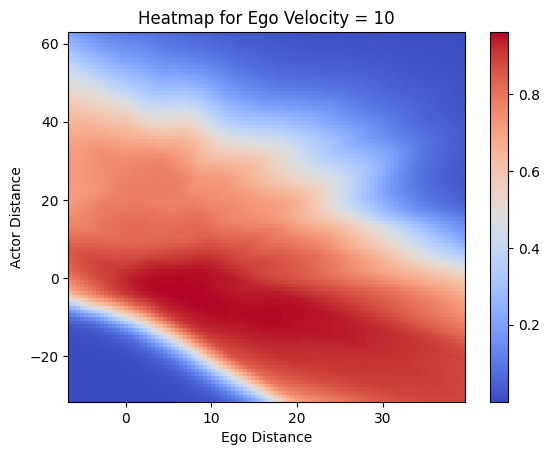

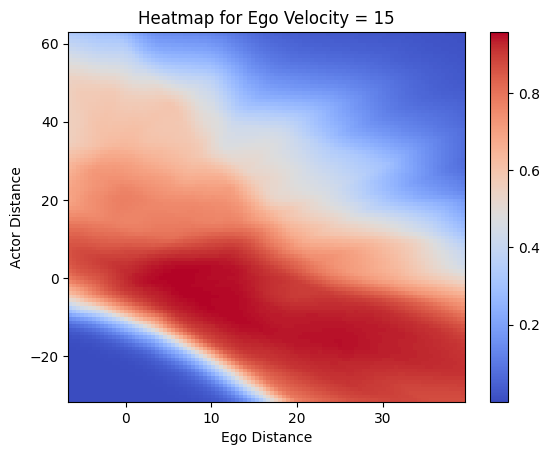

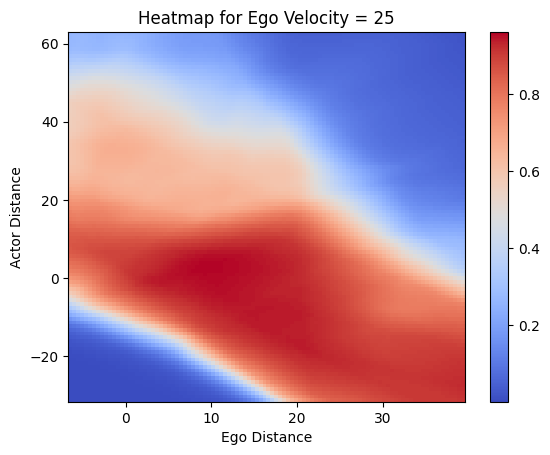

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range and resolution of your grid
num_points = 100  # the number of points along each axis
ego_distance_range = [df['ego_distance'].min(), df['ego_distance'].max()]
actor_distance_range = [df['actor_distance'].min(), df['actor_distance'].max()]

# Create a 2D grid
ego_distance_grid, actor_distance_grid = np.meshgrid(
    np.linspace(*ego_distance_range, num_points),
    np.linspace(*actor_distance_range, num_points)
)

# Velocities to iterate over
velocities = [10, 15, 25]

# Loop through velocities
for specified_ego_velocity in velocities:
    # Create grid with the specified ego_velocity value
    grid = np.stack([ego_distance_grid, np.full_like(ego_distance_grid, specified_ego_velocity), actor_distance_grid], axis=-1).reshape(-1, 3)
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Evaluate the model on the grid
    with torch.no_grad():
        predictions = net(grid_tensor).numpy()

    # Reshape predictions to have the same shape as the grid
    predictions = predictions.reshape(ego_distance_grid.shape)

    # Create a 2D heatmap
    plt.imshow(predictions, origin='lower', extent=[*ego_distance_range, *actor_distance_range], aspect='auto', cmap='coolwarm')
    
    # Add colorbar
    plt.colorbar()

    # Set labels and title
    plt.xlabel('Ego Distance')
    plt.ylabel('Actor Distance')
    plt.title(f'Heatmap for Ego Velocity = {specified_ego_velocity}')

    plt.show()


In [46]:
# Export to ONNX format
dummy_input = torch.randn(1, 3).float()  # Assuming an input shape of (batch_size, input_dim)
torch.onnx.export(net, dummy_input, "./risk_function/surrogate_risk_model.onnx")